**Checking for requirements**

In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No GPU found")

CUDA available: True
GPU count: 1
Current device: 0
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
print("Python version:", sys.version)

try:
    import torch
    print("✅ PyTorch installed:", torch.__version__)
except:
    print("❌ PyTorch NOT installed")

try:
    import transformers
    print("✅ Transformers installed:", transformers.__version__)
except:
    print("❌ Transformers NOT installed")

try:
    from transformers.models.distilbert import DistilBertForSequenceClassification
    print("✅ DistilBERT module accessible")
except Exception as e:
    print("❌ DistilBERT import failed:", e)

Python version: 3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
✅ PyTorch installed: 2.7.1+cu118
✅ Transformers installed: 4.57.3
✅ DistilBERT module accessible


**Loading Dataset**

In [2]:
import os
import pandas as pd

# Go from: Code/Urgency Detection → Code → Project Root
PROJECT_ROOT = os.path.dirname(os.path.dirname(os.getcwd()))

DATA_PATH = os.path.join(
    PROJECT_ROOT,
    "Cleaned data",
    "final_email_dataset_clipped.csv"
)

df = pd.read_csv(DATA_PATH)

print(df.shape)
print(df.columns)
print(df.head())

(502505, 5)
Index(['clean_text', 'category', 'auto_category', 'auto_urgency',
       'email_length'],
      dtype='object')
                                          clean_text category auto_category  \
0  Traveling to have a business meeting takes the...  unknown         other   
1                     test successful.  way to go!!!  unknown         other   
2  Randy,\n Can you send me a schedule of the sal...  unknown       request   
3                  Let's shoot for Tuesday at 11:45.  unknown         other   
4  Greg,\n How about either next Tuesday or Thurs...  unknown         other   

  auto_urgency  email_length  
0          low           783  
1          low            30  
2       medium           185  
3          low            33  
4          low            57  


In [4]:
df_copy = df.copy()
df_bert = df[['clean_text', 'auto_urgency']].sample(50000, random_state=42)

**Label Encoding**

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_bert['label'] = le.fit_transform(df_bert['auto_urgency'])


In [6]:
label_map = dict(zip(le.classes_, le.transform(le.classes_)))

**Train-Test Split**

In [7]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_bert['clean_text'],
    df_bert['label'],
    test_size=0.2,
    stratify=df_bert['label'],
    random_state=42
)


**Tokentization using DistiBERT**

In [8]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_enc = tokenizer(list(train_texts), truncation=True, padding=True, max_length=256)
val_enc = tokenizer(list(val_texts), truncation=True, padding=True, max_length=256)


**Building Dataset**

In [9]:
import torch

class EmailDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)  # Added dtype=torch.long
        return item

    def __len__(self):
        return len(self.labels)

**Loading DistilBERT**

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=6   # adjust if you merged classes
)

print("✅ DistilBERT loaded successfully")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ DistilBERT loaded successfully


**Training the Model**

In [11]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    logging_steps=500,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"  # Disable TensorBoard and other logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=EmailDataset(train_enc, train_labels),
    eval_dataset=EmailDataset(val_enc, val_labels)
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.261000,0.262714
2,0.210500,0.243911


TrainOutput(global_step=5000, training_loss=0.2741984176635742, metrics={'train_runtime': 3453.6636, 'train_samples_per_second': 23.164, 'train_steps_per_second': 1.448, 'total_flos': 5299073925120000.0, 'train_loss': 0.2741984176635742, 'epoch': 2.0})

In [12]:
from sklearn.metrics import classification_report

preds = trainer.predict(EmailDataset(val_enc, val_labels))
y_pred = preds.predictions.argmax(axis=1)

print(classification_report(val_labels, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

        high       0.90      0.66      0.76      1055
         low       0.92      0.93      0.93      4165
      medium       0.89      0.94      0.92      4780

    accuracy                           0.91     10000
   macro avg       0.91      0.84      0.87     10000
weighted avg       0.91      0.91      0.90     10000



In [13]:
model.save_pretrained("models/urgency_distilbert_classifier")
tokenizer.save_pretrained("models/urgency_distilbert_classifier")
# Verify saved model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

loaded_model = AutoModelForSequenceClassification.from_pretrained("models/urgency_distilbert_classifier")
loaded_tokenizer = AutoTokenizer.from_pretrained("models/urgency_distilbert_classifier")

print("✅ Model and tokenizer loaded successfully from saved directory")

✅ Model and tokenizer loaded successfully from saved directory


In [15]:
predictions = trainer.predict(
    EmailDataset(val_enc, val_labels)
)

y_true = val_labels.values
y_pred = predictions.predictions.argmax(axis=1)


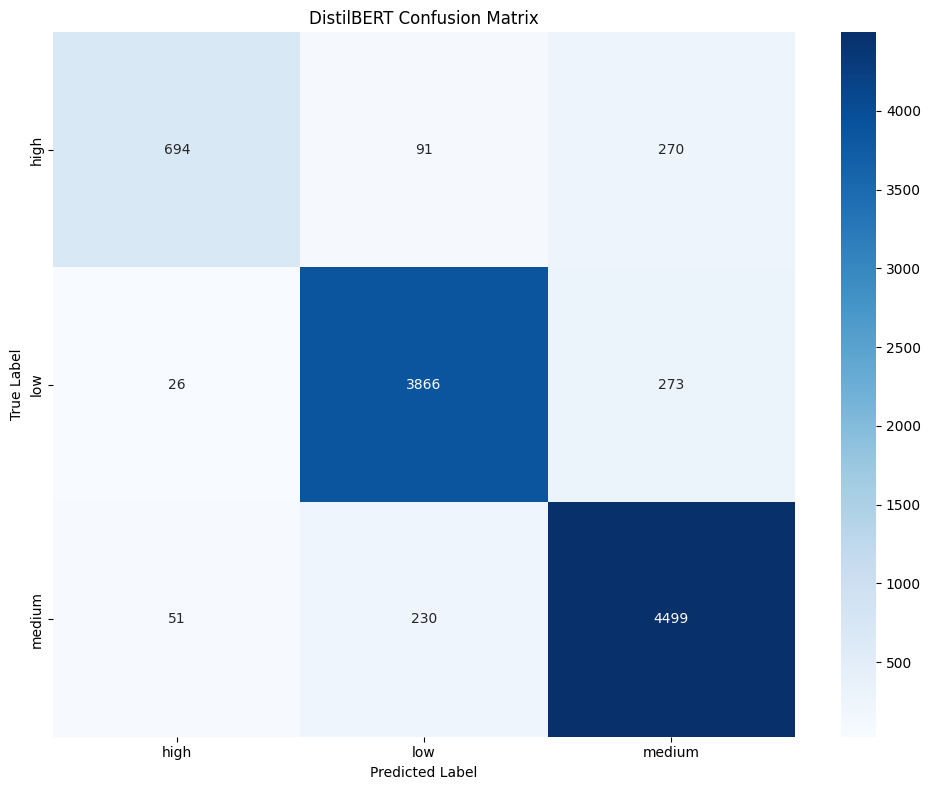

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("DistilBERT Confusion Matrix")
plt.tight_layout()
plt.show()
